# Compare canopy structure before and after treatments on Cle Elum Ridge   
# Clean version
### Notebook contents 
* Opening the netcdfs created in the *rapid_model_create_netcdf.ipynb* notebook 
* comparing the canopy height models from the different datasets to see change in forest structure 
* also, taking a look at the difference between my method dce and Giulia's 

created by Cassie Lumbrazo\
date: October 2023\
python environment: **raster**

In [2]:
# import packages 
# %matplotlib widget
%matplotlib inline

# plotting packages 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set_theme()
# plt.rcParams['figure.figsize'] = [12,6] #overriding size

# data packages 
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime

import csv 
import copy 
import os.path 

import geopandas as gpd
# import rasterio as rio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import rioxarray
import rasterio
# import rasterstats
import scipy

In [3]:
import plotly.express as px

In [4]:
# The two netcdfs created in the previous notebook, one has some correction for negative snow depth values and the other has the snow depth values cut at zero
# ds = xr.open_dataset('/home/lumbraca/raster/data/rapid_model_cleandata_create_netcdf_cutatzero.nc') # for the snow depth values cut a zero
ds = xr.open_dataset('/home/lumbraca/raster/data/rapid_model_cleandata_create_netcdf_negtozero.nc') # for the snow depth values negative to zeros
# ds.close() # how to close a dataset 

In [5]:
ds

<xarray.Dataset>
Dimensions:                   (x: 2564, y: 1388, band: 1)
Coordinates:
  * x                         (x) float64 4.65e+05 4.65e+05 ... 4.676e+05
  * y                         (y) float64 2.111e+05 2.111e+05 ... 2.097e+05
  * band                      (band) int32 1
    spatial_ref               int32 ...
Data variables: (12/36)
    hs_rapid_set1             (band, y, x) float32 ...
    hs_rapid_set2             (band, y, x) float32 ...
    hs_rapid_set3             (band, y, x) float32 ...
    hs_rapid_set2_maskpiles   (band, y, x) float32 ...
    hs_rapid_set3_maskpiles   (band, y, x) float32 ...
    chmws_rapid               (band, y, x) float32 ...
    ...                        ...
    dah_reclass               (band, y, x) float32 ...
    dce_rapid_reclass         (band, y, x) float32 ...
    giulia_dce_rapid_reclass  (band, y, x) float64 ...
    dce_ncalm_reclass         (band, y, x) float32 ...
    hs_rapid                  (band, y, x) float32 ...
    chmas_rapid               (band, y, x) float32 ...

# Plot all three canopy height models together 
* snow off chm 
* ncalm chmws 
* rapid chmws 

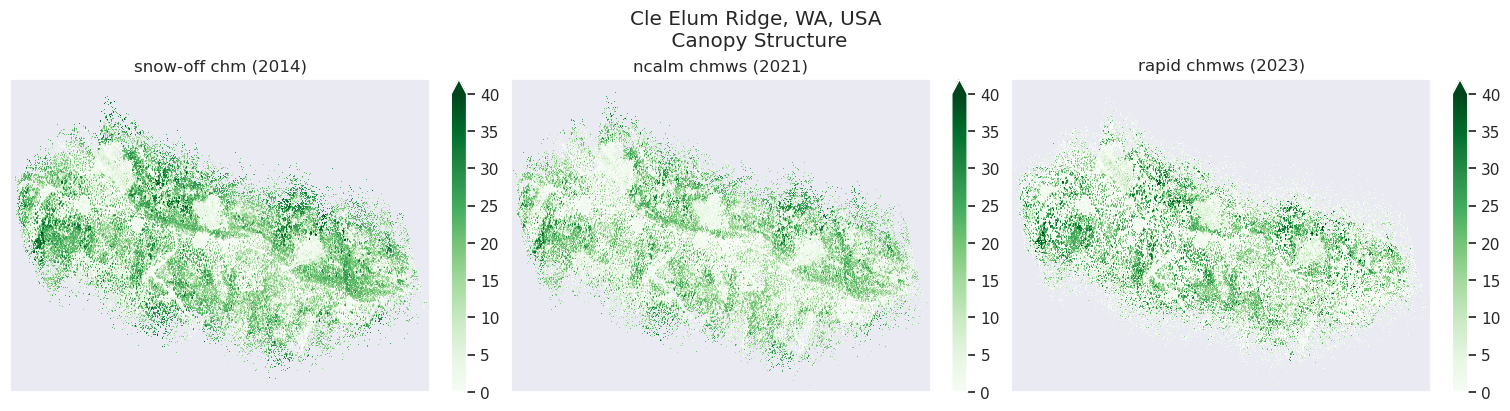

In [6]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15,4), constrained_layout = True)

fig.suptitle('Cle Elum Ridge, WA, USA\n Canopy Structure')

ds.chm_snowoff.plot(ax=axes[0], cmap='Greens', vmin=0, vmax=40, cbar_kwargs={'label':''}) 
ds.chmws_ncalm.plot(ax=axes[1], cmap='Greens', vmin=0, vmax=40, cbar_kwargs={'label':''}) 
ds.chmws_rapid.plot(ax=axes[2], cmap='Greens', vmin=0, vmax=40, cbar_kwargs={'label':''}) 

axes[0].set_title('snow-off chm (2014)')
axes[1].set_title('ncalm chmws (2021)')
axes[2].set_title('rapid chmws (2023)')

# fix a few things on the figure 
axes[0].set_xlabel('')
axes[0].set_ylabel('') 
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].set_xlabel('')
axes[1].set_ylabel('') 
axes[1].set_xticks([])
axes[1].set_yticks([])

axes[2].set_xlabel('')
axes[2].set_ylabel('') 
axes[2].set_xticks([])
axes[2].set_yticks([])

plt.show()

## Add a CHM buffer for edge effects of RAPID lidar data 
To do the buffer, we want to buffer the rapid chm, then clip the other two chm to the rapid model

In [7]:
# first creating a binary mask
# if there are values then 1, if not then 0 
chm_mask = ds['chmws_rapid'].copy(deep=True) # first cope chmws
chm_mask = chm_mask.fillna(-1000) # then filling the nans in the mask with 500 to make this easier
chm_mask = chm_mask.where(chm_mask < -50, 1) # where condition is FALSE, fill with 1 
chm_mask = chm_mask.where(chm_mask > -50, 0) # where condition is FALSE, fill with 0 

# now, we take the dce_mask and do the erosion thing with it to create the fixed mask 
fixed_mask = scipy.ndimage.binary_erosion(chm_mask, structure=np.ones((1,10,10))).astype(chm_mask.dtype) # had to add the 1 to the 50x50 for dimensions

# For the chmws mask, we do not accoutn for large edge effects, so a buffer of 5-10 meters should work. Let's do 10. 

# add the fixed mask to the dataset 
ds['chm_mask'] = xr.DataArray(fixed_mask,dims = ['band','y','x'])

# Now, go mask my OG dataset by the fixed_mask to remove the edges of dce 
ds['chmws_rapid_raw'] = ds['chmws_rapid'].copy(deep=True) # saving dce into a variable for the dataset 
ds['chmws_rapid'] = ds['chmws_rapid'].where(ds['chm_mask'] >= 1) # resaving the mask dce into dce variable 

In [8]:
ds['diff_chm_rapid_snowoff'] = ds['chmws_rapid'] - ds['chm_snowoff']
ds['diff_chm_ncalm_snowoff'] = ds['chmws_ncalm'] - ds['chm_snowoff']
ds['diff_chm_rapid_ncalm'] =   ds['chmws_rapid'] - ds['chmws_ncalm']

ds['diff_chm_snowoff_rapid'] =  ds['chm_snowoff']- ds['chmws_rapid']
ds['diff_chm_snowoff_ncalm'] =  ds['chm_snowoff']- ds['chmws_ncalm']
ds['diff_chm_ncalm_rapid'] =    ds['chmws_ncalm']- ds['chmws_rapid'] 

That looks a lot better, now check out how the differencing looks. 

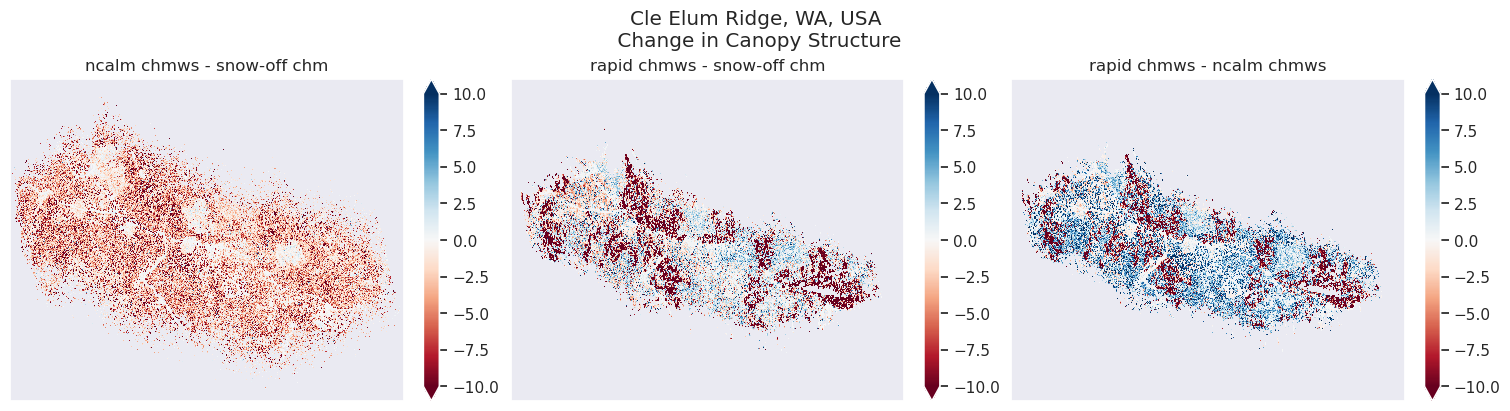

In [9]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15,4), constrained_layout = True)

fig.suptitle('Cle Elum Ridge, WA, USA\n Change in Canopy Structure')

ds.diff_chm_ncalm_snowoff.plot(ax=axes[0], cmap='RdBu', vmin=-10, vmax=10, cbar_kwargs={'label':''}) 
ds.diff_chm_rapid_snowoff.plot(ax=axes[1], cmap='RdBu', vmin=-10, vmax=10, cbar_kwargs={'label':''}) 
ds.diff_chm_rapid_ncalm.plot(ax=axes[2], cmap='RdBu', vmin=-10, vmax=10, cbar_kwargs={'label':''}) 

axes[0].set_title('ncalm chmws - snow-off chm')
axes[1].set_title('rapid chmws - snow-off chm')
axes[2].set_title('rapid chmws - ncalm chmws')

# fix a few things on the figure 
axes[0].set_xlabel('')
axes[0].set_ylabel('') 
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].set_xlabel('')
axes[1].set_ylabel('') 
axes[1].set_xticks([])
axes[1].set_yticks([])

axes[2].set_xlabel('')
axes[2].set_ylabel('') 
axes[2].set_xticks([])
axes[2].set_yticks([])

plt.show()

So, for this difference map, the locations that are negative are there trees have been removed between snow off and rapid.

In [10]:
ds['lidar_canopychange'] = ds['diff_chm_rapid_snowoff'].where(ds['diff_chm_rapid_snowoff'] < 0) # removed trees
ds['lidar_nocanopychange'] = ds['diff_chm_rapid_snowoff'].where(ds['diff_chm_rapid_snowoff'] >= 0) # stayed the same 

However, we do not want to consider trees being removed if there is a change of 2 meters or so. 
Let's take a look at the histogram of the difference to see how much it is. 

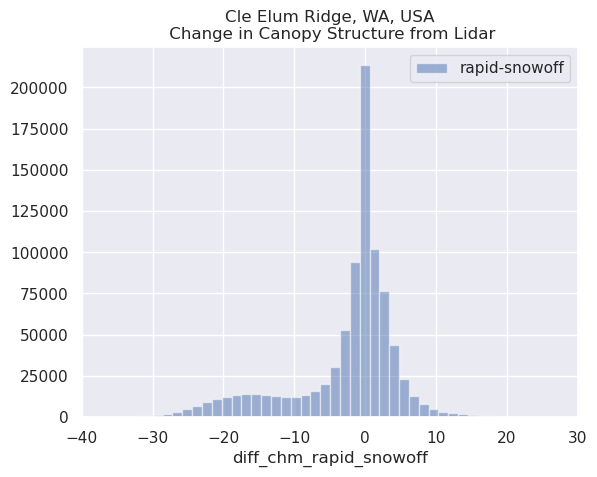

In [11]:
ds['diff_chm_rapid_snowoff'].plot.hist(bins=100, alpha=0.5)
# ds['diff_chm_rapid_ncalm'].plot.hist(bins=100, alpha=0.5)
# ds['diff_chm_ncalm_snowoff'].plot.hist(bins=100, alpha=0.5)
plt.xlim(-40,30)
plt.title('Cle Elum Ridge, WA, USA\n Change in Canopy Structure from Lidar')
plt.legend(['rapid-snowoff','rapid-ncalm','ncalm-snowoff'])
plt.show()

Deciding to proceed with a threshold of 5 meters for now based on the histogram and analysis. 

In [12]:
ds['lidar_canopychange'] = ds['diff_chm_rapid_snowoff'].where(ds['diff_chm_rapid_snowoff'] < -5) # removed trees, can change this... but for now, 5
ds['lidar_nocanopychange'] = ds['diff_chm_rapid_snowoff'].where(ds['diff_chm_rapid_snowoff'] >= 0) # stayed the same 

# also, remove outliers from the change canopy 
ds['lidar_nocanopychange'] = ds['lidar_nocanopychange'].where(ds['lidar_nocanopychange'] < 40) # I saw some outliers when plotting so remove those points

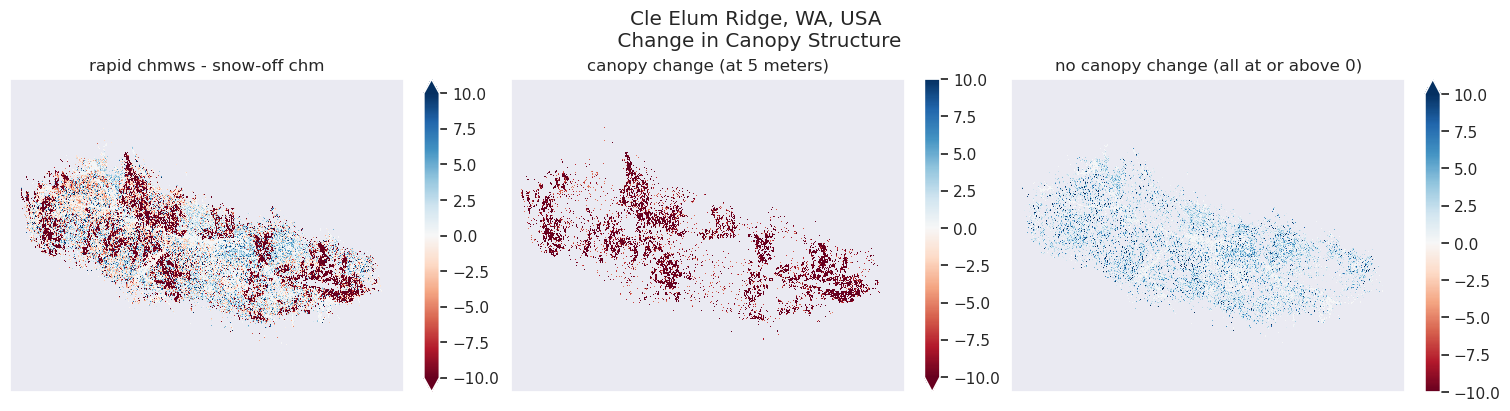

In [13]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15,4), constrained_layout = True)

fig.suptitle('Cle Elum Ridge, WA, USA\n Change in Canopy Structure')

ds.diff_chm_rapid_snowoff.plot(ax=axes[0], cmap='RdBu', vmin=-10, vmax=10, cbar_kwargs={'label':''}) 
ds.lidar_canopychange.plot(ax=axes[1], cmap='RdBu', vmin=-10, vmax=10, cbar_kwargs={'label':''}) 
ds.lidar_nocanopychange.plot(ax=axes[2], cmap='RdBu', vmin=-10, vmax=10, cbar_kwargs={'label':''}) 

axes[0].set_title('rapid chmws - snow-off chm')
axes[1].set_title('canopy change (at 5 meters)')
axes[2].set_title('no canopy change (all at or above 0)')

# fix a few things on the figure 
axes[0].set_xlabel('')
axes[0].set_ylabel('') 
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].set_xlabel('')
axes[1].set_ylabel('') 
axes[1].set_xticks([])
axes[1].set_yticks([])

axes[2].set_xlabel('')
axes[2].set_ylabel('') 
axes[2].set_xticks([])
axes[2].set_yticks([])

plt.show()

Also, make a binary change/ no change options to remove values 

In [14]:
# use the change canopy and no change canopy to make a binary variable
ds['lidar_canopychange_binary'] = ds['lidar_canopychange'].copy(deep=True) # first copy the variable
ds['lidar_canopychange_binary'] = ds['lidar_canopychange_binary'].fillna(0) # then fill the nans with 0
ds['lidar_canopychange_binary'] = ds['lidar_canopychange_binary'].where(ds['lidar_canopychange_binary'] == 0, 1) # where condition is FALSE, fill with 1
ds['lidar_canopychange_binary'] = ds['lidar_canopychange_binary'].where(ds['diff_chm_rapid_snowoff'])
ds['lidar_canopychange_binary'] = ds['lidar_canopychange_binary'].where(ds.diff_chm_rapid_snowoff.notnull()) # now, just make nans where there is no data really

In [15]:
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap

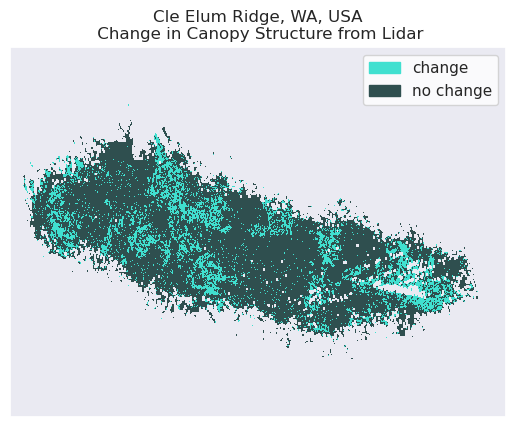

In [57]:
ds.lidar_canopychange_binary.plot(cmap=ListedColormap(['darkslategrey','turquoise']), add_colorbar=False)

# Add a legend for labels
legend_labels = {"turquoise": "change", 
                 "darkslategrey": "no change"}

patches = [Patch(color=color, label=label)
           for color, label in legend_labels.items()]

plt.legend(handles=patches,
        #   bbox_to_anchor=(1.35, 1),
          bbox_to_anchor=(1, 1),
          facecolor="white")

# ax.set_axis_off()
plt.title('Cle Elum Ridge, WA, USA\n Change in Canopy Structure from Lidar')
plt.xlabel('')
plt.ylabel('') 
plt.xticks([])
plt.yticks([])
plt.show()

And, add BAF as a canopy change option too

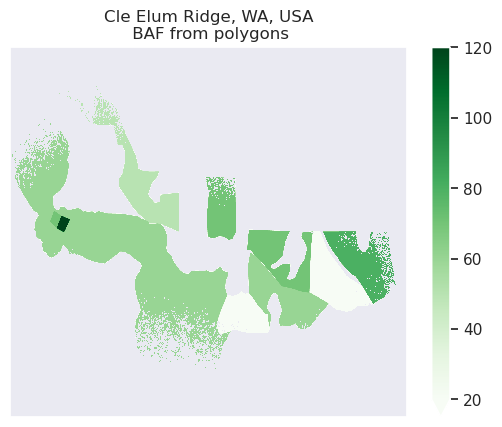

In [17]:
ds.baf.plot(cmap='Greens', vmin=20, vmax=120, cbar_kwargs={'label':''})

# ax.set_axis_off()
plt.title('Cle Elum Ridge, WA, USA\n BAF from polygons')
plt.xlabel('')
plt.ylabel('') 
plt.xticks([])
plt.yticks([])
plt.show()

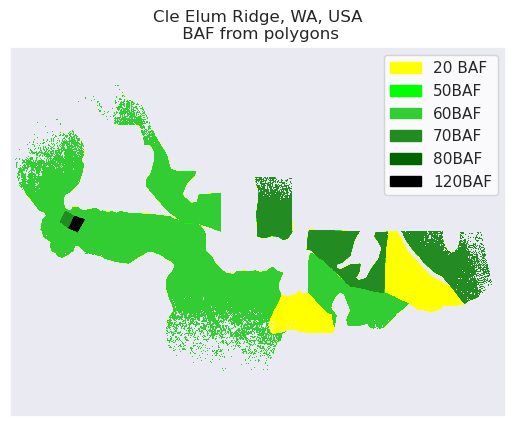

In [18]:
ds.baf.plot(cmap=ListedColormap(['yellow', 'lime', 'limegreen', 'forestgreen','darkgreen','black']), add_colorbar=False)

# Add a legend for labels
legend_labels = {"yellow": "20 BAF", 
                 "lime": "50BAF",
                 "limegreen": "60BAF",
                 "forestgreen": "70BAF",
                 "darkgreen": "80BAF",
                 "black": "120BAF"}

patches = [Patch(color=color, label=label)
           for color, label in legend_labels.items()]

plt.legend(handles=patches,
        #   bbox_to_anchor=(1.35, 1),
          bbox_to_anchor=(1, 1),
          facecolor="white")

# ax.set_axis_off()
plt.title('Cle Elum Ridge, WA, USA\n BAF from polygons')
plt.xlabel('')
plt.ylabel('') 
plt.xticks([])
plt.yticks([])
plt.show()

In [19]:
# create binary variable for baf
ds['baf_canopychange_binary'] = np.nan 
ds['baf_canopychange_binary'] = ds['baf_canopychange_binary'].fillna(0) # then fill the nans with 0
ds['baf_canopychange_binary'] = ds['baf_canopychange_binary'].where(~(ds['baf'] > 0), 1) # any BAF means canopy change
ds['baf_canopychange_binary'] = ds['baf_canopychange_binary'].where(ds.diff_chm_rapid_snowoff.notnull()) # now, just make nans where there is no data really

# also, create this variable to call later with the lidar change
ds['baf_canopychange'] = ds['baf_canopychange_binary'].where(ds['baf_canopychange_binary'] == 1, np.nan)
ds['baf_nocanopychange']= ds['baf_canopychange_binary'].where(ds['baf_canopychange_binary'] == 0, np.nan)

Plot the two canopy change features next to eachother

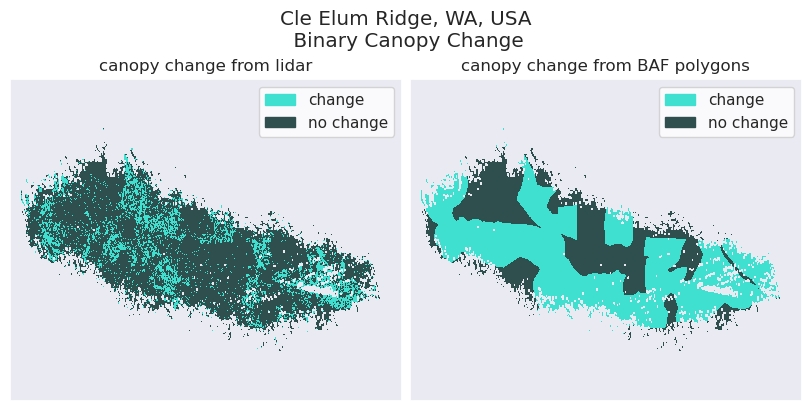

In [20]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8,4), constrained_layout = True)

fig.suptitle('Cle Elum Ridge, WA, USA\n Binary Canopy Change')

p1 = ds['lidar_canopychange_binary'].plot(ax=axes[0], cmap=ListedColormap(['darkslategrey','turquoise']), add_colorbar=False) 
p2 = ds['baf_canopychange_binary'].plot(ax=axes[1],   cmap=ListedColormap(['darkslategrey','turquoise']), add_colorbar=False)  


# Add a legend for labels
legend_labels = {"turquoise": "change", 
                 "darkslategrey": "no change"}

patches = [Patch(color=color, label=label)
           for color, label in legend_labels.items()]

axes[0].legend(handles=patches,
          bbox_to_anchor=(1, 1),
          facecolor="white")

axes[1].legend(handles=patches,
          bbox_to_anchor=(1, 1),
          facecolor="white")


# fix a few things on the figure 
axes[0].set_title('canopy change from lidar')
axes[1].set_title('canopy change from BAF polygons')

axes[0].set_xlabel('')
axes[0].set_ylabel('') 
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].set_xlabel('')
axes[1].set_ylabel('') 
axes[1].set_xticks([])
axes[1].set_yticks([])

plt.show()

## Aspect and Heat Index
* create binary objects for these also

In [21]:
# create binary object for dah
ds['dah_binary'] = np.nan
ds['dah_binary'] = ds['dah_binary'].where(~(ds['dah'] >= 0), 1)  # where DAH is greater than 0, then 1 for high heat index
ds['dah_binary'] = ds['dah_binary'].where(~(ds['dah'] < 0), -1) # where DAH is less than or equal to 0, then -1 for low heat index
ds['dah_binary'] = ds['dah_binary'].where(ds.diff_chm_rapid_snowoff.notnull()) # now, just make nans where there is no data really

In [22]:
# the numbers above show the calculate bounds for this option
ds['aspect_north'] = ds['aspect'].where((ds['aspect'] >= 325) | (ds['aspect'] <= 55)) # greater than 300 or less than 120 north
ds['aspect_south'] = ds['aspect'].where((ds['aspect'] >= 155) & (ds['aspect'] <= 245)) # between 120 and 300 south

# also, create an aspect binary variable to use later 
ds['aspect_binary'] = np.nan
ds['aspect_binary'] = ds['aspect_binary'].where(~((ds['aspect'] >= 325) | (ds['aspect'] <= 55)), 0) # where not false (true) fill 0
ds['aspect_binary'] = ds['aspect_binary'].where(~((ds['aspect'] >= 155) & (ds['aspect'] <= 245)), 1) 

# therefore, south is 0 and north is 1 
ds['aspect_binary'] = ds['aspect_binary'].where(ds.diff_chm_rapid_snowoff.notnull()) # now, just make nans where there is no data really

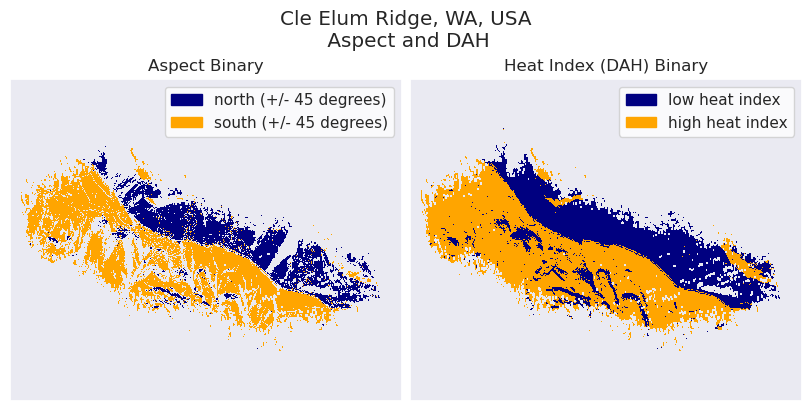

In [23]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8,4), constrained_layout = True)

fig.suptitle('Cle Elum Ridge, WA, USA\n Aspect and DAH')

ds['aspect_binary'].plot(ax=axes[0], vmin=0, vmax=1, cmap=ListedColormap(['navy','orange']), add_colorbar=False) 
ds['dah_binary'].plot(ax=axes[1], vmin=0, vmax=1, cmap=ListedColormap(['navy','orange']), add_colorbar=False)  


# Add a legend for labels, to have different labels for each plot
legend_labels1 = {"navy": "north (+/- 45 degrees)", 
                 "orange": "south (+/- 45 degrees)"}

legend_labels2 = {"navy": "low heat index", 
                 "orange": "high heat index"}                 

patches1 = [Patch(color=color, label=label)
           for color, label in legend_labels1.items()]

patches2 = [Patch(color=color, label=label)
           for color, label in legend_labels2.items()]

axes[0].legend(handles=patches1,
          bbox_to_anchor=(1, 1),
          facecolor="white")

axes[1].legend(handles=patches2,
          bbox_to_anchor=(1, 1),
          facecolor="white")


axes[0].set_title('Aspect Binary')
axes[1].set_title('Heat Index (DAH) Binary')

# fix a few things on the figure 
axes[0].set_xlabel('')
axes[0].set_ylabel('') 
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].set_xlabel('')
axes[1].set_ylabel('') 
axes[1].set_xticks([])
axes[1].set_yticks([])

plt.show()

Okay, and now, we want to fine where the forest changed or did not, on each aspect 

In [24]:
# lidar canopy change
# aspect 
ds['lidar_canopychange_north'] = ds['lidar_canopychange'].where(ds['aspect_north'] >= 0) # north
ds['lidar_canopychange_south'] = ds['lidar_canopychange'].where(ds['aspect_south'] >= 0) # south

ds['lidar_nocanopychange_north'] = ds['lidar_nocanopychange'].where(ds['aspect_north'] >= 0) # north
ds['lidar_nocanopychange_south'] = ds['lidar_nocanopychange'].where(ds['aspect_south'] >= 0) # south

# dah 
ds['lidar_canopychange_dahneg'] = ds['lidar_canopychange'].where(ds['dah_binary'] == -1) # low dah
ds['lidar_canopychange_dahpos'] = ds['lidar_canopychange'].where(ds['dah_binary'] == 1) # high dah

ds['lidar_nocanopychange_dahneg'] = ds['lidar_nocanopychange'].where(ds['dah_binary'] == -1) # low dah
ds['lidar_nocanopychange_dahpos'] = ds['lidar_nocanopychange'].where(ds['dah_binary'] == 1) # high dah

# same, with baf canopy change
# aspect 
ds['baf_canopychange_north'] = ds['baf_canopychange'].where(ds['aspect_north'] >= 0) # north
ds['baf_canopychange_south'] = ds['baf_canopychange'].where(ds['aspect_south'] >= 0) # south

ds['baf_nocanopychange_north'] = ds['baf_nocanopychange'].where(ds['aspect_north'] >= 0) # north
ds['baf_nocanopychange_south'] = ds['baf_nocanopychange'].where(ds['aspect_south'] >= 0) # south

# dah 
ds['baf_canopychange_dahneg'] = ds['baf_canopychange'].where(ds['dah_binary'] == -1) # low dah
ds['baf_canopychange_dahpos'] = ds['baf_canopychange'].where(ds['dah_binary'] == 1) # high dah

ds['baf_nocanopychange_dahneg'] = ds['baf_nocanopychange'].where(ds['dah_binary'] == -1) # low dah
ds['baf_nocanopychange_dahpos'] = ds['baf_nocanopychange'].where(ds['dah_binary'] == 1) # high dah

In [25]:
# now, save snow depth as a variable for each of those conditions, where the values are not null
ds['hs_lidar_canopychange_north'] = ds['hs_rapid'].where(ds['lidar_canopychange_north'].notnull())
ds['hs_lidar_canopychange_south'] = ds['hs_rapid'].where(ds['lidar_canopychange_south'].notnull())
ds['hs_lidar_nocanopychange_north'] = ds['hs_rapid'].where(ds['lidar_nocanopychange_north'].notnull())
ds['hs_lidar_nocanopychange_south'] = ds['hs_rapid'].where(ds['lidar_nocanopychange_south'].notnull())

ds['hs_lidar_canopychange_dahneg'] = ds['hs_rapid'].where(ds['lidar_canopychange_dahneg'].notnull())
ds['hs_lidar_canopychange_dahpos'] = ds['hs_rapid'].where(ds['lidar_canopychange_dahpos'].notnull())
ds['hs_lidar_nocanopychange_dahneg'] = ds['hs_rapid'].where(ds['lidar_nocanopychange_dahneg'].notnull())
ds['hs_lidar_nocanopychange_dahpos'] = ds['hs_rapid'].where(ds['lidar_nocanopychange_dahpos'].notnull())

# same, with baf canopy change
ds['hs_baf_canopychange_north'] = ds['hs_rapid'].where(ds['baf_canopychange_north'].notnull())
ds['hs_baf_canopychange_south'] = ds['hs_rapid'].where(ds['baf_canopychange_south'].notnull())
ds['hs_baf_nocanopychange_north'] = ds['hs_rapid'].where(ds['baf_nocanopychange_north'].notnull())
ds['hs_baf_nocanopychange_south'] = ds['hs_rapid'].where(ds['baf_nocanopychange_south'].notnull())


ds['hs_baf_canopychange_dahneg'] = ds['hs_rapid'].where(ds['baf_canopychange_dahneg'].notnull())
ds['hs_baf_canopychange_dahpos'] = ds['hs_rapid'].where(ds['baf_canopychange_dahpos'].notnull())
ds['hs_baf_nocanopychange_dahneg'] = ds['hs_rapid'].where(ds['baf_nocanopychange_dahneg'].notnull())
ds['hs_baf_nocanopychange_dahpos'] = ds['hs_rapid'].where(ds['baf_nocanopychange_dahpos'].notnull())

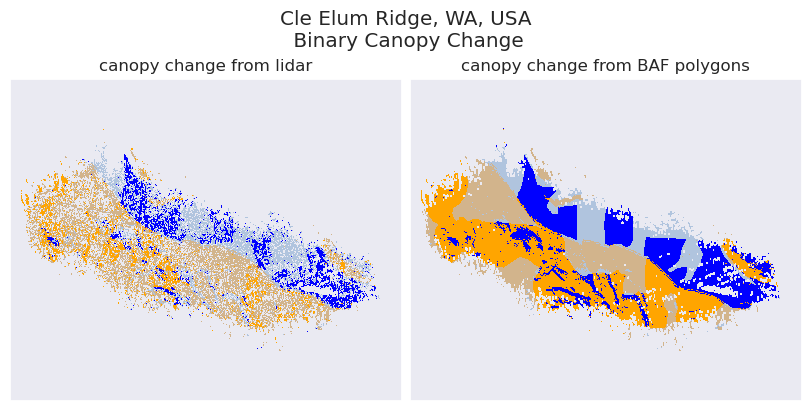

In [62]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8,4), constrained_layout = True)

fig.suptitle('Cle Elum Ridge, WA, USA\n Binary Canopy Change')

# lidar
p1 = ds['hs_lidar_nocanopychange_dahpos'].plot(ax=axes[0], cmap=ListedColormap(['tan']),  
                                               label='no canopy change high heat index', add_colorbar=False) 
p2 = ds['hs_lidar_nocanopychange_dahneg'].plot(ax=axes[0], cmap=ListedColormap(['lightsteelblue']),
                                               label='no canopy change low heat index', add_colorbar=False) 

p3 = ds['hs_lidar_canopychange_dahneg'].plot(ax=axes[0], cmap=ListedColormap(['blue']),  
                                               label='canopy change high heat index', add_colorbar=False) 
p4 = ds['hs_lidar_canopychange_dahpos'].plot(ax=axes[0], cmap=ListedColormap(['orange']),
                                               label='canopy change low heat index', add_colorbar=False) 

# baf
p1 = ds['hs_baf_nocanopychange_dahpos'].plot(ax=axes[1], cmap=ListedColormap(['tan']),  
                                               label='no canopy change high heat index', add_colorbar=False) 
p2 = ds['hs_baf_nocanopychange_dahneg'].plot(ax=axes[1], cmap=ListedColormap(['lightsteelblue']),
                                               label='no canopy change low heat index', add_colorbar=False) 

p3 = ds['hs_baf_canopychange_dahneg'].plot(ax=axes[1], cmap=ListedColormap(['blue']),  
                                               label='canopy change high heat index', add_colorbar=False) 
p4 = ds['hs_baf_canopychange_dahpos'].plot(ax=axes[1], cmap=ListedColormap(['orange']),
                                               label='canopy change low heat index', add_colorbar=False) 


# # Add a legend for labels
# legend_labels = {"turquoise": "change", 
#                  "darkslategrey": "no change"}

# patches = [Patch(color=color, label=label)
#            for color, label in legend_labels.items()]

# axes[0].legend(handles=patches,
#           bbox_to_anchor=(1, 1),
#           facecolor="white")

# axes[1].legend(handles=patches,
#           bbox_to_anchor=(1, 1),
#           facecolor="white")


# fix a few things on the figure 
axes[0].set_title('canopy change from lidar')
axes[1].set_title('canopy change from BAF polygons')

axes[0].set_xlabel('')
axes[0].set_ylabel('') 
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].set_xlabel('')
axes[1].set_ylabel('') 
axes[1].set_xticks([])
axes[1].set_yticks([])

plt.show()

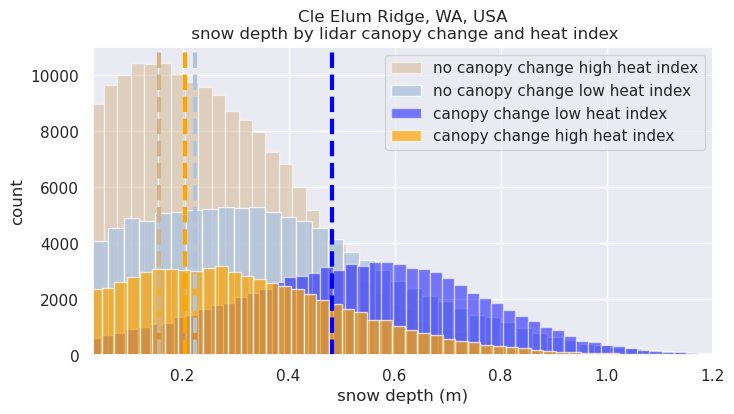

In [49]:
# plot histograms of the four groups 
fig, axes = plt.subplots(1, 1, figsize=(8,4))

p1 = ds['hs_lidar_nocanopychange_dahpos'].plot.hist(bins=100, label='no canopy change high heat index', alpha=.5, color='tan')
p2 = ds['hs_lidar_nocanopychange_dahneg'].plot.hist(bins=100, label='no canopy change low heat index', alpha=.8, color='lightsteelblue')

p4 = ds['hs_lidar_canopychange_dahneg'].plot.hist(bins=100, label='canopy change low heat index', alpha=.5, color='blue')
p3 = ds['hs_lidar_canopychange_dahpos'].plot.hist(bins=100, label='canopy change high heat index', alpha=.7, color='orange')

# plot the median lines for the histograms\
width=3
plt.axvline(ds['hs_lidar_nocanopychange_dahneg'].median(), color='lightsteelblue', linestyle='dashed', linewidth=width)
plt.axvline(ds['hs_lidar_nocanopychange_dahpos'].median(), color='tan', linestyle='dashed', linewidth=width)
plt.axvline(ds['hs_lidar_canopychange_dahneg'].median(), color='blue', linestyle='dashed', linewidth=width)
plt.axvline(ds['hs_lidar_canopychange_dahpos'].median(), color='orange', linestyle='dashed', linewidth=width)

# legend order
order=[0,1,3,2]
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

# constants
plt.title('Cle Elum Ridge, WA, USA\n snow depth by lidar canopy change and heat index')
plt.xlabel('snow depth (m)')
plt.ylabel('count')

plt.xlim(0.03,1.2)
plt.ylim(0,11000)
plt.legend()
plt.show()

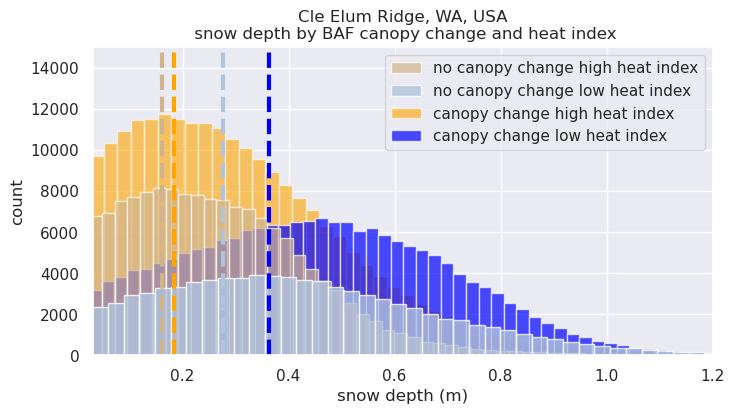

In [48]:
# plot histograms of the four groups 
fig, axes = plt.subplots(1, 1, figsize=(8,4))

p3 = ds['hs_baf_canopychange_dahpos'].plot.hist(bins=100, label='canopy change high heat index', alpha=.6, color='orange')
p4 = ds['hs_baf_canopychange_dahneg'].plot.hist(bins=100, label='canopy change low heat index', alpha=.7, color='blue')

p1 = ds['hs_baf_nocanopychange_dahpos'].plot.hist(bins=100, label='no canopy change high heat index', alpha=.7, color='tan')
p2 = ds['hs_baf_nocanopychange_dahneg'].plot.hist(bins=100, label='no canopy change low heat index', alpha=.8, color='lightsteelblue')

# plot the median lines for the histograms\
width=3
plt.axvline(ds['hs_baf_nocanopychange_dahneg'].median(), color='lightsteelblue', linestyle='dashed', linewidth=width)
plt.axvline(ds['hs_baf_nocanopychange_dahpos'].median(), color='tan', linestyle='dashed', linewidth=width)
plt.axvline(ds['hs_baf_canopychange_dahneg'].median(), color='blue', linestyle='dashed', linewidth=width)
plt.axvline(ds['hs_baf_canopychange_dahpos'].median(), color='orange', linestyle='dashed', linewidth=width)

# legend order
order=[2,3,0,1]
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

# constants
plt.title('Cle Elum Ridge, WA, USA\n snow depth by BAF canopy change and heat index')
plt.xlabel('snow depth (m)')
plt.ylabel('count')

plt.xlim(0.03,1.2)
plt.ylim(0,15000)
plt.show()

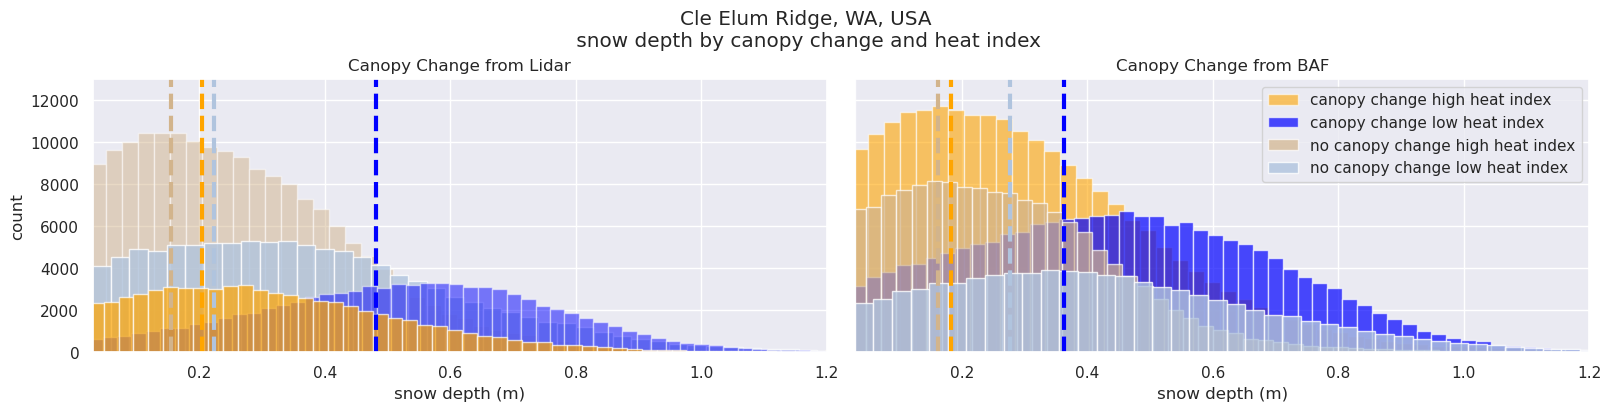

In [56]:
# plot histograms of the four groups 
fig, axes = plt.subplots(1, 2, figsize=(16,4), sharex=True, sharey=True, constrained_layout=True)

# LIDAR 
p1 = ds['hs_lidar_nocanopychange_dahpos'].plot.hist(ax=axes[0], bins=100, label='no canopy change high heat index', alpha=.5, color='tan')
p2 = ds['hs_lidar_nocanopychange_dahneg'].plot.hist(ax=axes[0], bins=100, label='no canopy change low heat index', alpha=.8, color='lightsteelblue')

p4 = ds['hs_lidar_canopychange_dahneg'].plot.hist(ax=axes[0], bins=100, label='canopy change low heat index', alpha=.5, color='blue')
p3 = ds['hs_lidar_canopychange_dahpos'].plot.hist(ax=axes[0], bins=100, label='canopy change high heat index', alpha=.7, color='orange')

width=3
axes[0].axvline(ds['hs_lidar_nocanopychange_dahneg'].median(), color='lightsteelblue', linestyle='dashed', linewidth=width)
axes[0].axvline(ds['hs_lidar_nocanopychange_dahpos'].median(), color='tan', linestyle='dashed', linewidth=width)
axes[0].axvline(ds['hs_lidar_canopychange_dahneg'].median(), color='blue', linestyle='dashed', linewidth=width)
axes[0].axvline(ds['hs_lidar_canopychange_dahpos'].median(), color='orange', linestyle='dashed', linewidth=width)

# # legend order
# order=[0,1,3,2]
# handles, labels = plt.gca().get_legend_handles_labels()
# axes[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order])


# BAF
p3 = ds['hs_baf_canopychange_dahpos'].plot.hist(ax=axes[1], bins=100, label='canopy change high heat index', alpha=.6, color='orange')
p4 = ds['hs_baf_canopychange_dahneg'].plot.hist(ax=axes[1], bins=100, label='canopy change low heat index', alpha=.7, color='blue')

p1 = ds['hs_baf_nocanopychange_dahpos'].plot.hist(ax=axes[1], bins=100, label='no canopy change high heat index', alpha=.7, color='tan')
p2 = ds['hs_baf_nocanopychange_dahneg'].plot.hist(ax=axes[1], bins=100, label='no canopy change low heat index', alpha=.8, color='lightsteelblue')

width=3
axes[1].axvline(ds['hs_baf_nocanopychange_dahneg'].median(), color='lightsteelblue', linestyle='dashed', linewidth=width)
axes[1].axvline(ds['hs_baf_nocanopychange_dahpos'].median(), color='tan', linestyle='dashed', linewidth=width)
axes[1].axvline(ds['hs_baf_canopychange_dahneg'].median(), color='blue', linestyle='dashed', linewidth=width)
axes[1].axvline(ds['hs_baf_canopychange_dahpos'].median(), color='orange', linestyle='dashed', linewidth=width)

# # legend order
# order=[2,3,0,1]
# handles, labels = plt.gca().get_legend_handles_labels()
# axes[1].legend([handles[idx] for idx in order],[labels[idx] for idx in order])

# constants
plt.suptitle('Cle Elum Ridge, WA, USA\n snow depth by canopy change and heat index')

axes[0].set_title('Canopy Change from Lidar')
axes[1].set_title('Canopy Change from BAF')

axes[0].set_xlabel('snow depth (m)')
axes[0].set_ylabel('count')
axes[0].set_xlim(0.03,1.2)
axes[0].set_ylim(0,13000)

axes[1].set_xlabel('snow depth (m)')
# axes[1].set_ylabel('count')
axes[1].set_xlim(0.03,1.2)
# axes[1].set_ylim(0,15000)

plt.legend()

plt.show()

Before moving on to the tidy df,\
**Lets make some calculations** for total SWE in each of the four groups. 

In [79]:
#lidar
ds['hs_lidar_nocanopychange_dahneg_sum'] = ds['hs_lidar_nocanopychange_dahneg'].sum(dim=['x','y'])
ds['hs_lidar_nocanopychange_dahpos_sum'] = ds['hs_lidar_nocanopychange_dahpos'].sum(dim=['x','y'])
ds['hs_lidar_canopychange_dahneg_sum']   = ds['hs_lidar_canopychange_dahneg'].sum(dim=['x','y'])
ds['hs_lidar_canopychange_dahpos_sum']   = ds['hs_lidar_canopychange_dahpos'].sum(dim=['x','y'])

# now, print all the totals 
print('Lidar Canopy Change and High Heat Index: ', ds['hs_lidar_canopychange_dahpos_sum'].values)
print('Lidar Canopy Change and Low Heat Index: ', ds['hs_lidar_canopychange_dahneg_sum'].values)
print('Lidar No Canopy Change and High Heat Index: ', ds['hs_lidar_nocanopychange_dahpos_sum'].values)
print('Lidar No Canopy Change and Low Heat Index: ', ds['hs_lidar_nocanopychange_dahneg_sum'].values)

Lidar Canopy Change and High Heat Index:  [22149.969]
Lidar Canopy Change and Low Heat Index:  [45383.27]
Lidar No Canopy Change and High Heat Index:  [51702.098]
Lidar No Canopy Change and Low Heat Index:  [42167.375]


In [78]:
# ds['hs_baf_nocanopychange_dahneg']
# ds['hs_baf_nocanopychange_dahpos']
# ds['hs_baf_canopychange_dahneg']
# ds['hs_baf_canopychange_dahpos']

# baf
ds['hs_baf_nocanopychange_dahneg_sum'] = ds['hs_baf_nocanopychange_dahneg'].sum(dim=['x','y'])
ds['hs_baf_nocanopychange_dahpos_sum'] = ds['hs_baf_nocanopychange_dahpos'].sum(dim=['x','y'])
ds['hs_baf_canopychange_dahneg_sum']   = ds['hs_baf_canopychange_dahneg'].sum(dim=['x','y'])
ds['hs_baf_canopychange_dahpos_sum']   = ds['hs_baf_canopychange_dahpos'].sum(dim=['x','y'])

# now, print all the totals 
print('BAF Canopy Change and High Heat Index: ', ds['hs_baf_canopychange_dahpos_sum'].values)
print('BAF Canopy Change and Low Heat Index: ', ds['hs_baf_canopychange_dahneg_sum'].values)
print('BAF No Canopy Change and High Heat Index: ', ds['hs_baf_nocanopychange_dahpos_sum'].values)
print('BAF No Canopy Change and Low Heat Index: ', ds['hs_baf_nocanopychange_dahneg_sum'].values)

BAF Canopy Change and High Heat Index:  [71045.16]
BAF Canopy Change and Low Heat Index:  [85231.86]
BAF No Canopy Change and High Heat Index:  [40852.66]
BAF No Canopy Change and Low Heat Index:  [36693.13]


In [100]:
# make bar charts of the totals
# put the totals into a dataframe
lidar_totals = pd.DataFrame({'lidar canopy change and high heat index': ds['hs_lidar_canopychange_dahpos_sum'].values,
                             'lidar canopy change and low heat index': ds['hs_lidar_canopychange_dahneg_sum'].values,
                             'lidar no canopy change and high heat index': ds['hs_lidar_nocanopychange_dahpos_sum'].values,
                             'lidar no canopy change and low heat index': ds['hs_lidar_nocanopychange_dahneg_sum'].values})

baf_totals = pd.DataFrame({'BAF Canopy change and high heat index': ds['hs_baf_canopychange_dahpos_sum'].values,
                                'BAF canopy change and low heat index': ds['hs_baf_canopychange_dahneg_sum'].values,
                                'BAF no canopy change and high heat index': ds['hs_baf_nocanopychange_dahpos_sum'].values,
                                'BAF no canopy change and low heat index': ds['hs_baf_nocanopychange_dahneg_sum'].values})

Text(0.5, 0, 'total snow depth (m)')

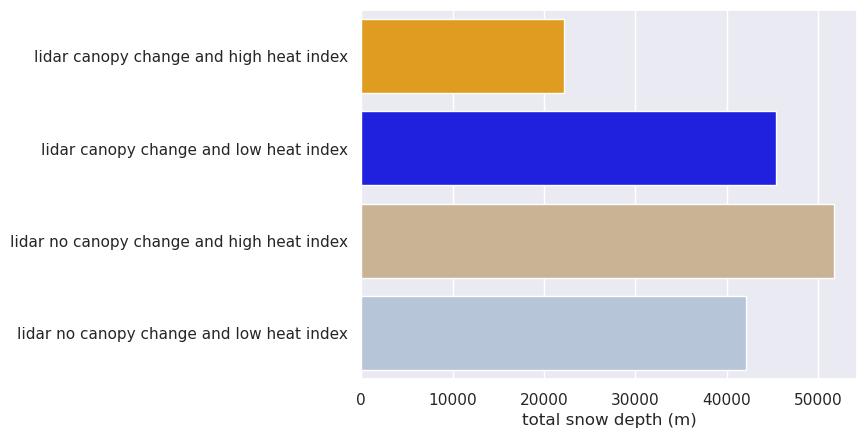

In [92]:
# make a color pallett 
mypal = ['orange', 'blue', 'tan', 'lightsteelblue']
sns.barplot(lidar_totals, orient='h', palette=mypal)
plt.xlabel('total snow depth (m)')

Text(0.5, 0, 'total snow depth (m)')

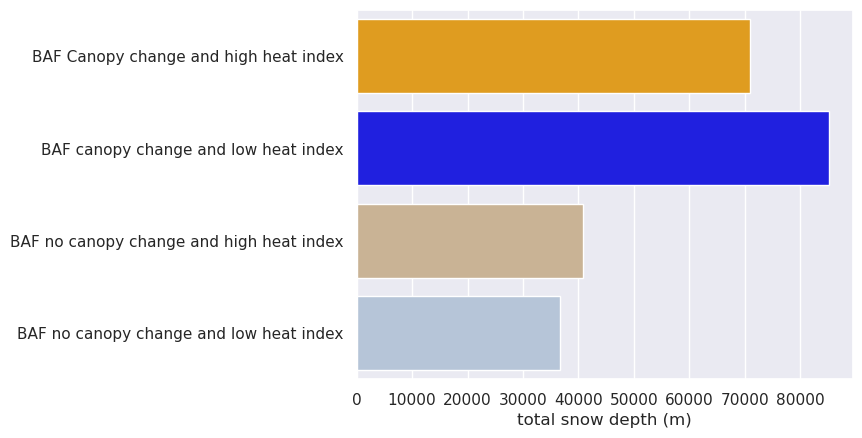

In [95]:
# make a color pallett 
mypal = ['orange', 'blue', 'tan', 'lightsteelblue']
sns.barplot(baf_totals, orient='h', palette=mypal)
plt.xlabel('total snow depth (m)')

In [97]:
# make bar charts of the totals
# put the totals into a dataframe
lidar_totals_swe = pd.DataFrame({'lidar canopy change and high heat index': ds['hs_lidar_canopychange_dahpos_sum'].values*300,
                             'lidar canopy change and low heat index': ds['hs_lidar_canopychange_dahneg_sum'].values*300,
                             'lidar no canopy change and high heat index': ds['hs_lidar_nocanopychange_dahpos_sum'].values*300,
                             'lidar no canopy change and low heat index': ds['hs_lidar_nocanopychange_dahneg_sum'].values*300})

baf_totals_swe = pd.DataFrame({'BAF Canopy change and high heat index': ds['hs_baf_canopychange_dahpos_sum'].values*300,
                                'BAF canopy change and low heat index': ds['hs_baf_canopychange_dahneg_sum'].values*300,
                                'BAF no canopy change and high heat index': ds['hs_baf_nocanopychange_dahpos_sum'].values*300,
                                'BAF no canopy change and low heat index': ds['hs_baf_nocanopychange_dahneg_sum'].values*300})

Let's just say the density was ~300 kg/m3 

Text(0.5, 0, 'SWE (mm)')

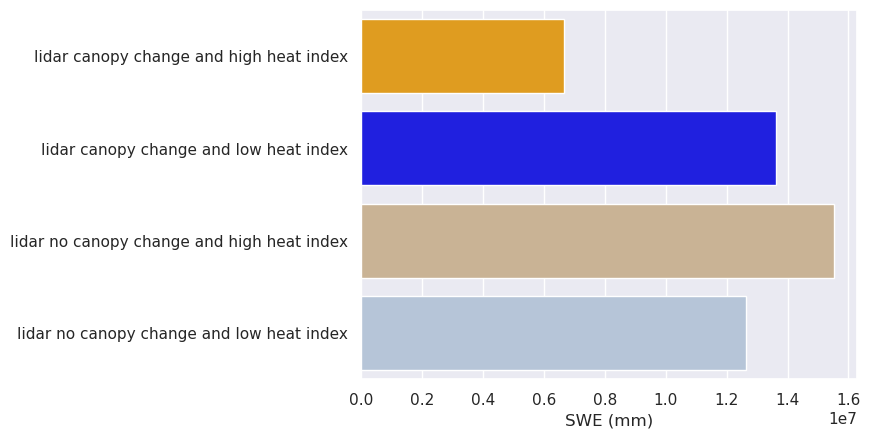

In [98]:
# make a color pallette
mypal = ['orange', 'blue', 'tan', 'lightsteelblue']
sns.barplot(lidar_totals_swe, orient='h', palette=mypal)
plt.xlabel('SWE (mm)')

Text(0.5, 0, 'SWE (mm)')

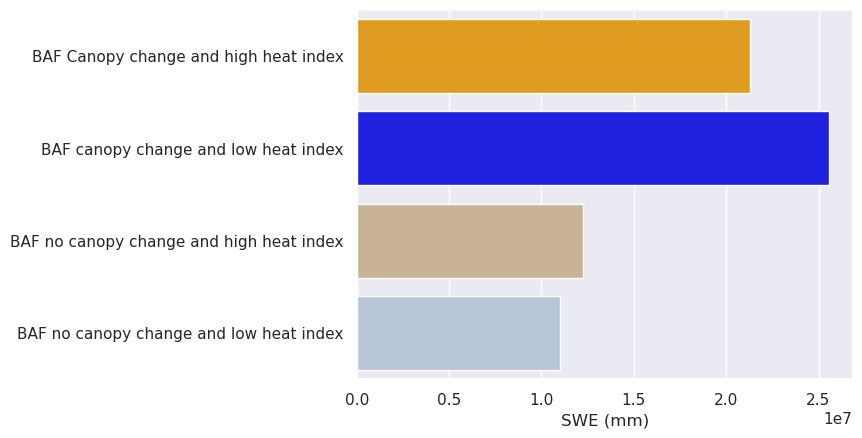

In [99]:
# make a color pallette
mypal = ['orange', 'blue', 'tan', 'lightsteelblue']
sns.barplot(baf_totals_swe, orient='h', palette=mypal)
plt.xlabel('SWE (mm)')

## Create Tidy df to work with

In [63]:
# Lets make a tidy dataframe with snow depth as the main variables, then attributes in the other columns like canopy change, aspect, etc.
dftidy = pd.DataFrame({'hs_rapid':ds['hs_rapid'].values.flatten(),
                       'dce_rapid':ds['dce_rapid'].values.flatten(),
                       'giulia_dce_rapid':ds['giulia_dce_rapid'].values.flatten(),
                       'hs_ncalm':ds['hs_ncalm'].values.flatten(),
                       'dce_ncalm':ds['dce_ncalm'].values.flatten(),
                       'dah': ds['dah'].values.flatten(),
                       'baf': ds['baf'].values.flatten(),
                       'aspect': ds['aspect'].values.flatten(),
                       'aspect_binary': ds['aspect_binary'].values.flatten(),
                       'lidar_canopychange_binary': ds['lidar_canopychange_binary'].values.flatten(),
                       'baf_canopychange_binary': ds['baf_canopychange_binary'].values.flatten()})

Create binary groups for easy plotting in box plots

In [64]:
# create a binary aspect for north and south
# first, create empty columns for aspect and canopy change with nan 
dftidy['aspect_text'] = np.nan
dftidy['lidar_canopychange_text'] = np.nan
dftidy['baf_canopychange_text'] = np.nan
dftidy['baf_text'] = np.nan
dftidy['dah_text'] = np.nan

# dah
dftidy['dah_text'] = dftidy['dah_text'].mask(dftidy['dah'] >= 0, 'high heat index')
dftidy['dah_text'] = dftidy['dah_text'].mask(dftidy['dah'] <  0 , 'low heat index')

# binary 0 is south, 1 is north
dftidy['aspect_text'] = dftidy['aspect_text'].mask(dftidy['aspect_binary'] == 0, 'north') # mask (replace) where true 
dftidy['aspect_text'] = dftidy['aspect_text'].mask(dftidy['aspect_binary'] == 1, 'south') # mask where true 

# create a binary canopy change for change and no change
# 0 is no change, 1 is change in canopy structure 
dftidy['lidar_canopychange_text'] = dftidy['lidar_canopychange_text'].mask(dftidy['lidar_canopychange_binary'] == 0, 'no change') # mask where true 
dftidy['lidar_canopychange_text'] = dftidy['lidar_canopychange_text'].mask(dftidy['lidar_canopychange_binary'] == 1, 'change')    # mask where true 

dftidy['baf_canopychange_text'] = dftidy['baf_canopychange_text'].mask(dftidy['baf_canopychange_binary'] == 0, 'no change') # mask where true 
dftidy['baf_canopychange_text'] = dftidy['baf_canopychange_text'].mask(dftidy['baf_canopychange_binary'] == 1, 'change')    # mask where true 

# create a baf option for plotting 
dftidy['baf_text'] = dftidy['baf_text'].mask(dftidy['baf'] == 20, '20 BAF') # mask where true 
dftidy['baf_text'] = dftidy['baf_text'].mask(dftidy['baf'] == 50, '50 BAF') 
dftidy['baf_text'] = dftidy['baf_text'].mask(dftidy['baf'] == 60, '60 BAF') 
dftidy['baf_text'] = dftidy['baf_text'].mask(dftidy['baf'] == 70, '70 BAF') 
dftidy['baf_text'] = dftidy['baf_text'].mask(dftidy['baf'] == 80, '80 BAF') 
dftidy['baf_text'] = dftidy['baf_text'].mask(dftidy['baf'] == 120,'120 BAF') 

dftidy.head()

,hs_rapid,dce_rapid,giulia_dce_rapid,hs_ncalm,dce_ncalm,dah,baf,aspect,aspect_binary,lidar_canopychange_binary,baf_canopychange_binary,aspect_text,lidar_canopychange_text,baf_canopychange_text,baf_text,dah_text
0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Try plotting it the other way, 

Text(0.5, 0, 'canopy change from lidar')

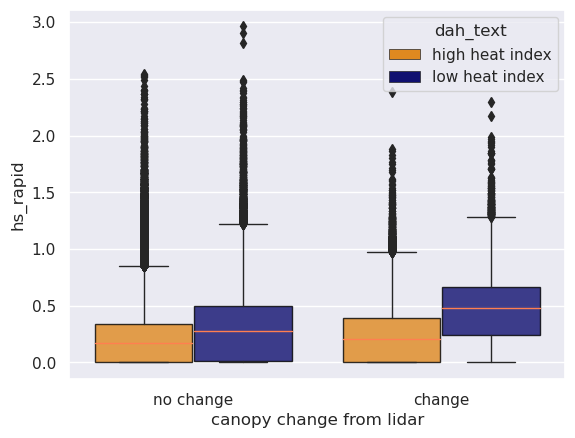

In [65]:
my_pal = {"low heat index": "navy", "high heat index": "darkorange"}
sns.boxplot(dftidy, x='lidar_canopychange_text', y='hs_rapid', hue='dah_text', 
            width=.8, linewidth=1, #fliersize=False,
            boxprops=dict(alpha=.8, edgecolor='black'), 
            medianprops={"color":"coral"},
            palette=my_pal, 
            order=['no change','change'], 
            hue_order=['high heat index','low heat index'])

plt.xlabel('canopy change from lidar')
# plt.ylim(0,2.8)

In [66]:
# create two different snow depths in the dftidy
# one for dah positive and one for dah negative
dftidy['hs_rapid_dahpos'] = np.nan
dftidy['hs_rapid_dahneg'] = np.nan

dftidy['hs_rapid_dahpos'] = dftidy['hs_rapid'].where(dftidy['dah'] >= 0) # dah positive
dftidy['hs_rapid_dahneg'] = dftidy['hs_rapid'].where(dftidy['dah'] <  0) # dah negative

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


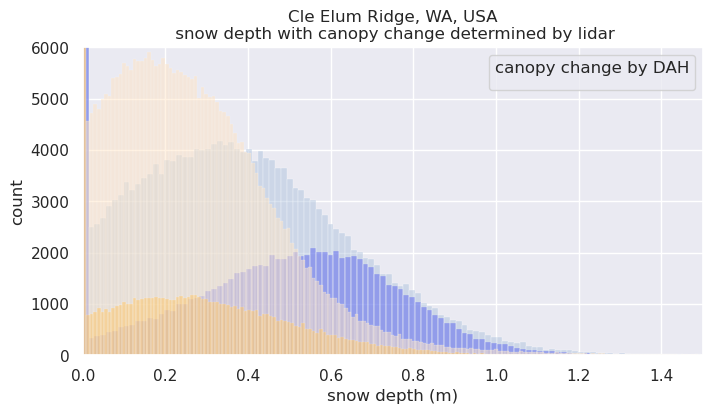

In [67]:
fig, axes = plt.subplots(1, 1, figsize=(8,4))

# create a histogram for the canopy change
my_pal1 = {"change": "blue", "no change": "lightsteelblue"}
my_pal2 = {"change": "orange", "no change": "bisque"}

sns.histplot(data=dftidy, x="hs_rapid_dahneg", hue='lidar_canopychange_text', 
             kde=False, palette=my_pal1)

sns.histplot(data=dftidy, x="hs_rapid_dahpos", hue='lidar_canopychange_text', 
             kde=False, palette=my_pal2)         

# constants
plt.xlim(0,1.5)
plt.ylim(0,6000)

axes.set_title('Cle Elum Ridge, WA, USA\n snow depth with canopy change determined by lidar')

axes.set_ylabel('count')
axes.set_xlabel('snow depth (m)')

# change the title of the legend 
handles, labels = axes.get_legend_handles_labels()
axes.legend(handles=handles[0:], labels=labels[0:], title='canopy change by DAH')

Now, compare with the baf canopy change

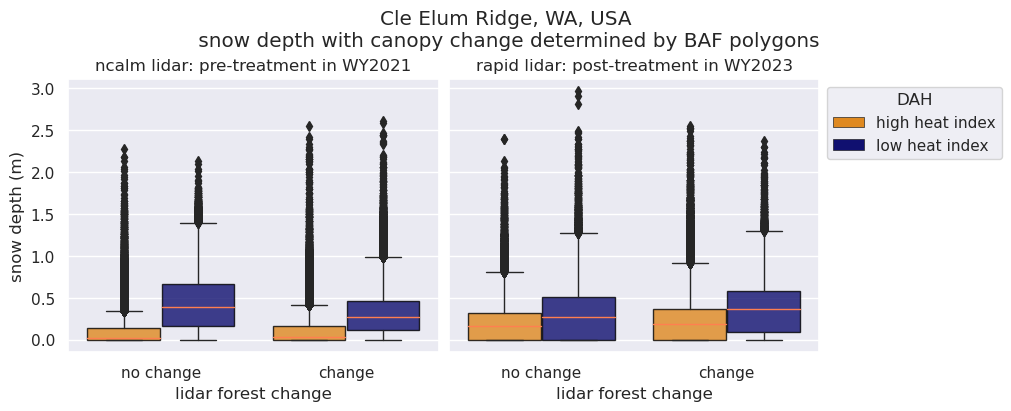

In [68]:
fig, axes = plt.subplots(1, 2, sharex=False, sharey=True, figsize=(10,4), constrained_layout = True)
my_pal = {"low heat index": "navy", "high heat index": "darkorange"}

sns.boxplot(dftidy, x='baf_canopychange_text', y='hs_ncalm', hue='dah_text',
            ax=axes[0], 
            width=.8, linewidth=1, #fliersize=False,
            boxprops=dict(alpha=.8, edgecolor='black'), 
            medianprops={"color":"coral"},
            palette=my_pal, 
            order=['no change','change'], 
            hue_order=['high heat index','low heat index'])

sns.boxplot(dftidy, x='baf_canopychange_text', y='hs_rapid', hue='dah_text',
            ax=axes[1], 
            width=.8, linewidth=1, #fliersize=False,
            boxprops=dict(alpha=.8, edgecolor='black'), 
            medianprops={"color":"coral"},
            palette=my_pal, 
            order=['no change','change'], 
            hue_order=['high heat index','low heat index'])

# constants
plt.suptitle('Cle Elum Ridge, WA, USA\n snow depth with canopy change determined by BAF polygons')
axes[0].set_title('ncalm lidar: pre-treatment in WY2021')
axes[1].set_title('rapid lidar: post-treatment in WY2023')

axes[0].set_ylabel('snow depth (m)')
axes[1].set_ylabel('')
axes[0].set_xlabel('lidar forest change')
axes[1].set_xlabel('lidar forest change')

# change the title of the legend 
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles=handles[0:], labels=labels[0:], title='DAH')

handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(handles=handles[0:], labels=labels[0:], title='DAH')

# move legends outside of the plot
sns.move_legend(axes[0], "upper left", bbox_to_anchor=(1, 1))
sns.move_legend(axes[1], "upper left", bbox_to_anchor=(1, 1))

# remove the legend on the first plot 
axes[0].get_legend().remove()

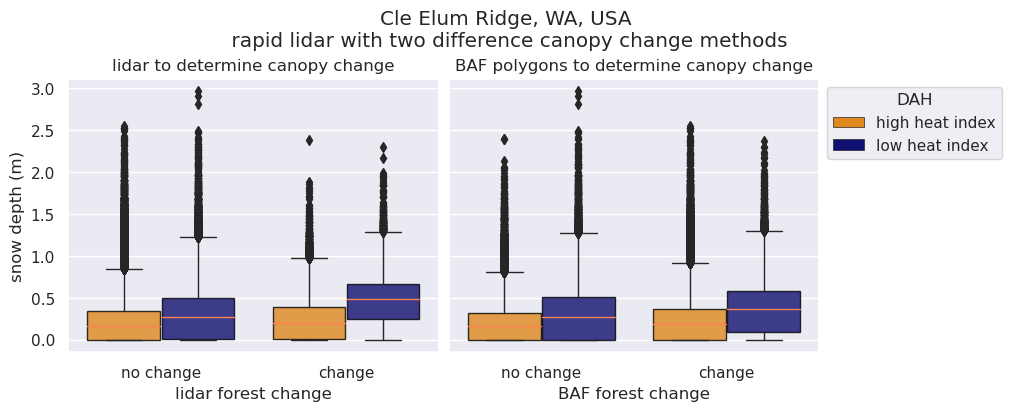

In [77]:
fig, axes = plt.subplots(1, 2, sharex=False, sharey=True, figsize=(10,4), constrained_layout = True)
my_pal = {"low heat index": "navy", "high heat index": "darkorange"}

sns.boxplot(dftidy, x='lidar_canopychange_text', y='hs_rapid', hue='dah_text',
            ax=axes[0], 
            width=.8, linewidth=1, #fliersize=False,
            boxprops=dict(alpha=.8, edgecolor='black'), 
            medianprops={"color":"coral"},
            palette=my_pal, 
            order=['no change','change'], 
            hue_order=['high heat index','low heat index'])

sns.boxplot(dftidy, x='baf_canopychange_text', y='hs_rapid', hue='dah_text',
            ax=axes[1], 
            width=.8, linewidth=1, #fliersize=False,
            boxprops=dict(alpha=.8, edgecolor='black'), 
            medianprops={"color":"coral"},
            palette=my_pal, 
            order=['no change','change'], 
            hue_order=['high heat index','low heat index'])

# constants
plt.suptitle('Cle Elum Ridge, WA, USA\n rapid lidar with two difference canopy change methods')
axes[1].set_title('BAF polygons to determine canopy change')
axes[0].set_title('lidar to determine canopy change')

axes[0].set_ylabel('snow depth (m)')
axes[1].set_ylabel('')
axes[1].set_xlabel('BAF forest change')
axes[0].set_xlabel('lidar forest change')

# change the title of the legend 
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles=handles[0:], labels=labels[0:], title='DAH')

handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(handles=handles[0:], labels=labels[0:], title='DAH')

# move legends outside of the plot
sns.move_legend(axes[0], "upper left", bbox_to_anchor=(1, 1))
sns.move_legend(axes[1], "upper left", bbox_to_anchor=(1, 1))

# remove the legend on the first plot 
axes[0].get_legend().remove()

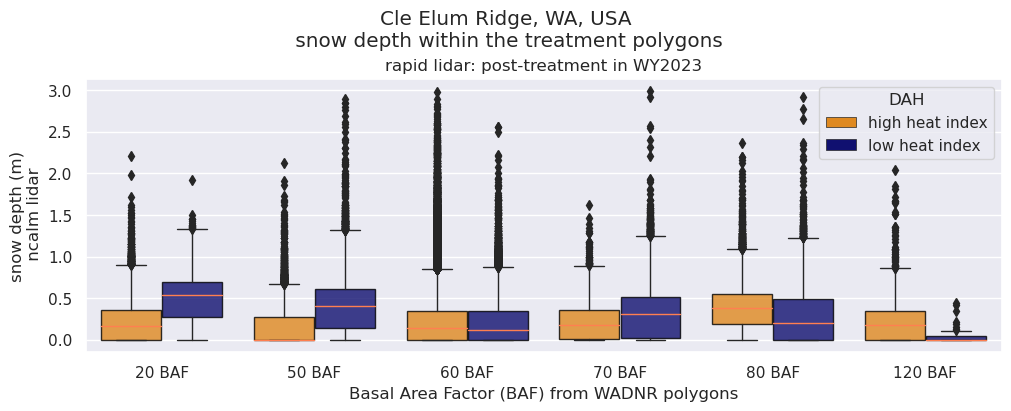

In [70]:
fig, axes = plt.subplots(1, 1, sharex=False, sharey=True, figsize=(10,4), constrained_layout = True)
my_pal = {"low heat index": "navy", "high heat index": "darkorange"}

sns.boxplot(dftidy, x='baf_text', y='hs_rapid', hue='dah_text', 
            width=.8, linewidth=1, #fliersize=False,
            boxprops=dict(alpha=.8, edgecolor='black'), 
            medianprops={"color":"coral"},
            palette=my_pal, 
            order=['20 BAF', '50 BAF', '60 BAF', '70 BAF', '80 BAF', '120 BAF'],
            hue_order=['high heat index','low heat index'])

# constants
plt.suptitle('Cle Elum Ridge, WA, USA\n snow depth within the treatment polygons')
axes.set_title('rapid lidar: post-treatment in WY2023')

axes.set_ylabel('snow depth (m)\n ncalm lidar')
axes.set_xlabel('Basal Area Factor (BAF) from WADNR polygons')

# change the title of the legend 
handles, labels = axes.get_legend_handles_labels()
axes.legend(handles=handles[0:], labels=labels[0:], title='DAH')

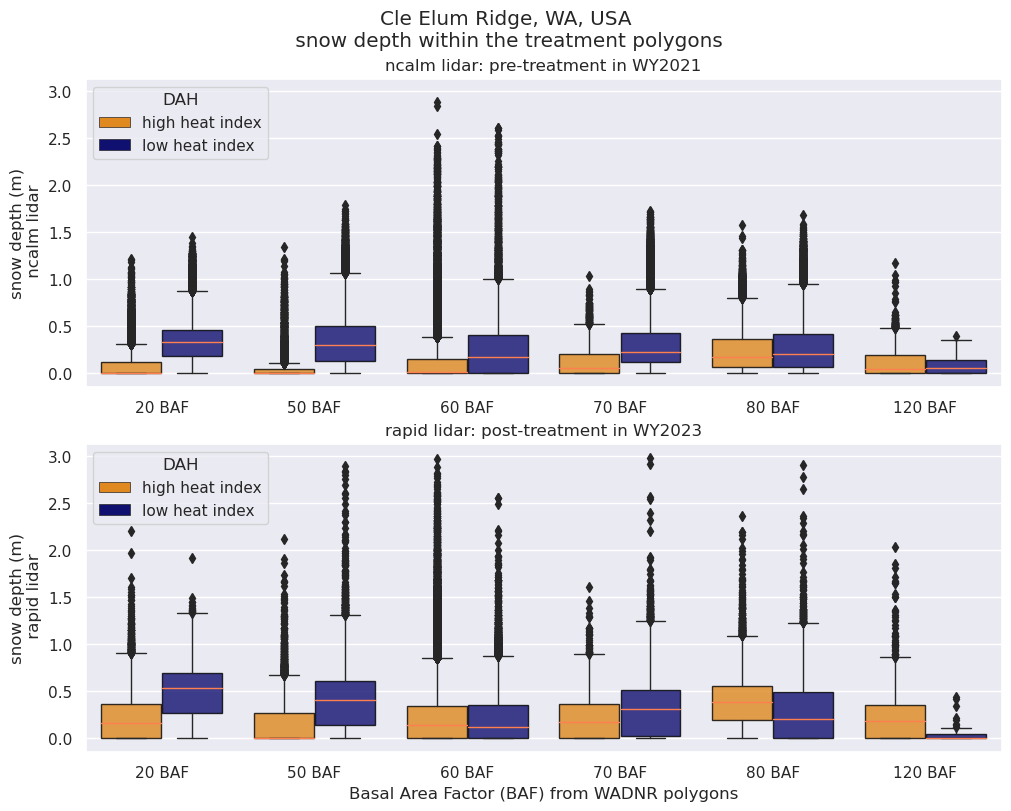

In [71]:
fig, axes = plt.subplots(2, 1, sharex=False, sharey=True, figsize=(10,8), constrained_layout = True)
my_pal = {"low heat index": "navy", "high heat index": "darkorange"}

sns.boxplot(dftidy, x='baf_text', y='hs_ncalm', hue='dah_text',
            ax=axes[0], 
            width=.8, linewidth=1, #fliersize=False,
            boxprops=dict(alpha=.8, edgecolor='black'), 
            medianprops={"color":"coral"},
            palette=my_pal, 
            order=['20 BAF', '50 BAF', '60 BAF', '70 BAF', '80 BAF', '120 BAF'],
            hue_order=['high heat index','low heat index'])

sns.boxplot(dftidy, x='baf_text', y='hs_rapid', hue='dah_text',
            ax=axes[1], 
            width=.8, linewidth=1, #fliersize=False,
            boxprops=dict(alpha=.8, edgecolor='black'), 
            medianprops={"color":"coral"},
            palette=my_pal, 
            order=['20 BAF', '50 BAF', '60 BAF', '70 BAF', '80 BAF', '120 BAF'],
            hue_order=['high heat index','low heat index'])

# constants
plt.suptitle('Cle Elum Ridge, WA, USA\n snow depth within the treatment polygons')
axes[0].set_title('ncalm lidar: pre-treatment in WY2021')
axes[1].set_title('rapid lidar: post-treatment in WY2023')

axes[0].set_ylabel('snow depth (m)\n ncalm lidar')
axes[1].set_ylabel('snow depth (m)\n rapid lidar')
axes[0].set_xlabel('')
axes[1].set_xlabel('Basal Area Factor (BAF) from WADNR polygons')

# change the title of the legend 
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles=handles[0:], labels=labels[0:], title='DAH')

handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(handles=handles[0:], labels=labels[0:], title='DAH')

# move legends outside of the plot
sns.move_legend(axes[0], "upper left")
sns.move_legend(axes[1], "upper left")

# remove the legend on the first plot 
# axes[1].get_legend().remove()

## Compare the DCEs
* compare both dce, mine and Giulia's
* if I want to use Giulia's, I might need to rerun with the CHM without removed piles! 

But, start by making them null where the snow depth is null so that we don't have the weird piles for Giulia DCE

In [72]:
# make dce null where snow depth is null 
ds['dce_rapid'] = ds['dce_rapid'].where(ds.hs_rapid.notnull()) 
ds['giulia_dce_rapid'] = ds['giulia_dce_rapid'].where(ds.hs_rapid.notnull()) 

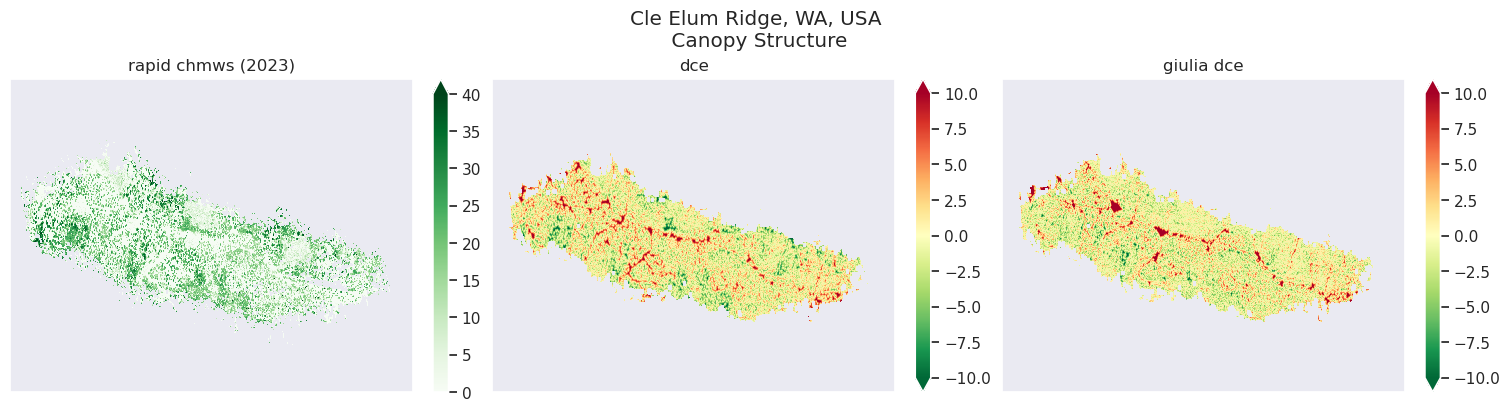

In [73]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15,4), constrained_layout = True)

fig.suptitle('Cle Elum Ridge, WA, USA\n Canopy Structure')

ds.chmws_rapid.plot(ax=axes[0], cmap='Greens', vmin=0, vmax=40, cbar_kwargs={'label':''}) 
ds.dce_rapid.plot(ax=axes[1], cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''})
ds.giulia_dce_rapid.plot(ax=axes[2], cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''})

axes[0].set_title('rapid chmws (2023)')
axes[1].set_title('dce')
axes[2].set_title('giulia dce')

# fix a few things on the figure 
axes[0].set_xlabel('')
axes[0].set_ylabel('') 
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].set_xlabel('')
axes[1].set_ylabel('') 
axes[1].set_xticks([])
axes[1].set_yticks([])

axes[2].set_xlabel('')
axes[2].set_ylabel('') 
axes[2].set_xticks([])
axes[2].set_yticks([])

plt.show()

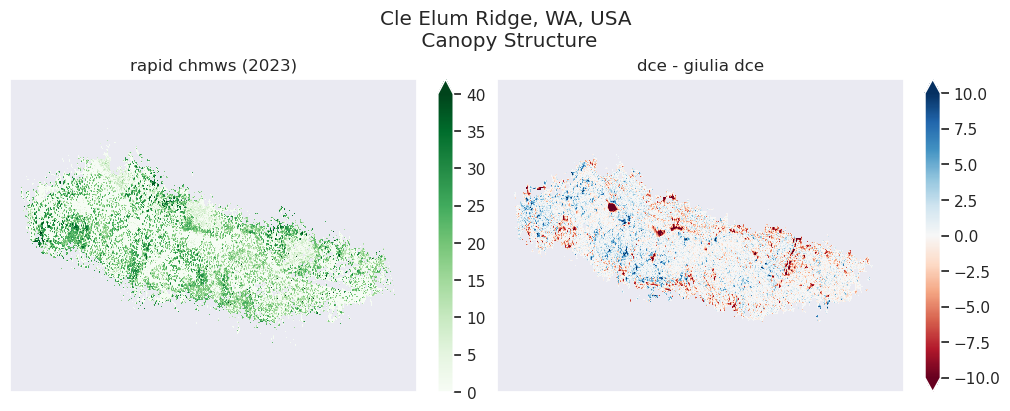

In [74]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10,4), constrained_layout = True)

fig.suptitle('Cle Elum Ridge, WA, USA\n Canopy Structure')

ds.chmws_rapid.plot(ax=axes[0], cmap='Greens', vmin=0, vmax=40, cbar_kwargs={'label':''}) 
(ds.dce_rapid - ds.giulia_dce_rapid).plot(ax=axes[1], cmap='RdBu', vmin=-10, vmax=10, cbar_kwargs={'label':''})

axes[0].set_title('rapid chmws (2023)')
axes[1].set_title('dce - giulia dce')

# fix a few things on the figure 
axes[0].set_xlabel('')
axes[0].set_ylabel('') 
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].set_xlabel('')
axes[1].set_ylabel('') 
axes[1].set_xticks([])
axes[1].set_yticks([])

plt.show()